# Bayesian Modeling in Python 
Code and exercises from the book:
https://bayesiancomputationbook.com/welcome.html

In [1]:
# Basic
import numpy as np
from scipy import stats
import pandas as pd
from patsy import bs, dmatrix
import matplotlib.pyplot as plt
# Exploratory Analysis of Bayesian Models
import arviz as az

In [2]:
# Probabilistic programming languages
import bambi as bmb
import pymc as pm
import tensorflow_probability as tfp
tfd = tfp.distributions

In [3]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
np.random.seed(521)
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

Solving the Beta-Binomial model: $ \theta ~ Beta(\alpha, \beta) $ by using the [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm).

In [4]:
def post(θ, Y, α=1, β=1):
    if 0 <= θ <= 1:
        prior = stats.beta(α, β).pdf(θ)
        like = stats.bernoulli(θ).pmf(Y).prod()
        prob = like * prior
    else:
        prob = -np.inf
    return prob

In [6]:
Y = stats.bernoulli(0.7).rvs(20)

In [7]:
n_iters = 1000
can_sd = 0.05
α = β = 1
θ = 0.5

trace = {"θ":np.zeros(n_iters)}
p2 = post(θ, Y, α, β)


for iter in range(n_iters):
    θ_can = stats.norm(θ, can_sd).rvs(1) #generate proposal distribution
    p1 = post(θ_can, Y, α, β)         #evaluate posterior
    pa = p1 / p2                                 #probability of acceptance
    
    if pa > stats.uniform(0, 1).rvs(1):          
        theta = θ_can
        p2 = p1
        
    np.put(trace["θ"], [iter,iter],[θ_can])    

(array([0.17185699, 0.40099964, 1.68992706, 4.21049624, 6.96020806,
        7.56170753, 4.89792419, 2.20549803, 0.37235681, 0.17185699]),
 array([0.32317592, 0.35808867, 0.39300142, 0.42791417, 0.46282691,
        0.49773966, 0.53265241, 0.56756516, 0.60247791, 0.63739066,
        0.67230341]),
 <BarContainer object of 10 artists>)

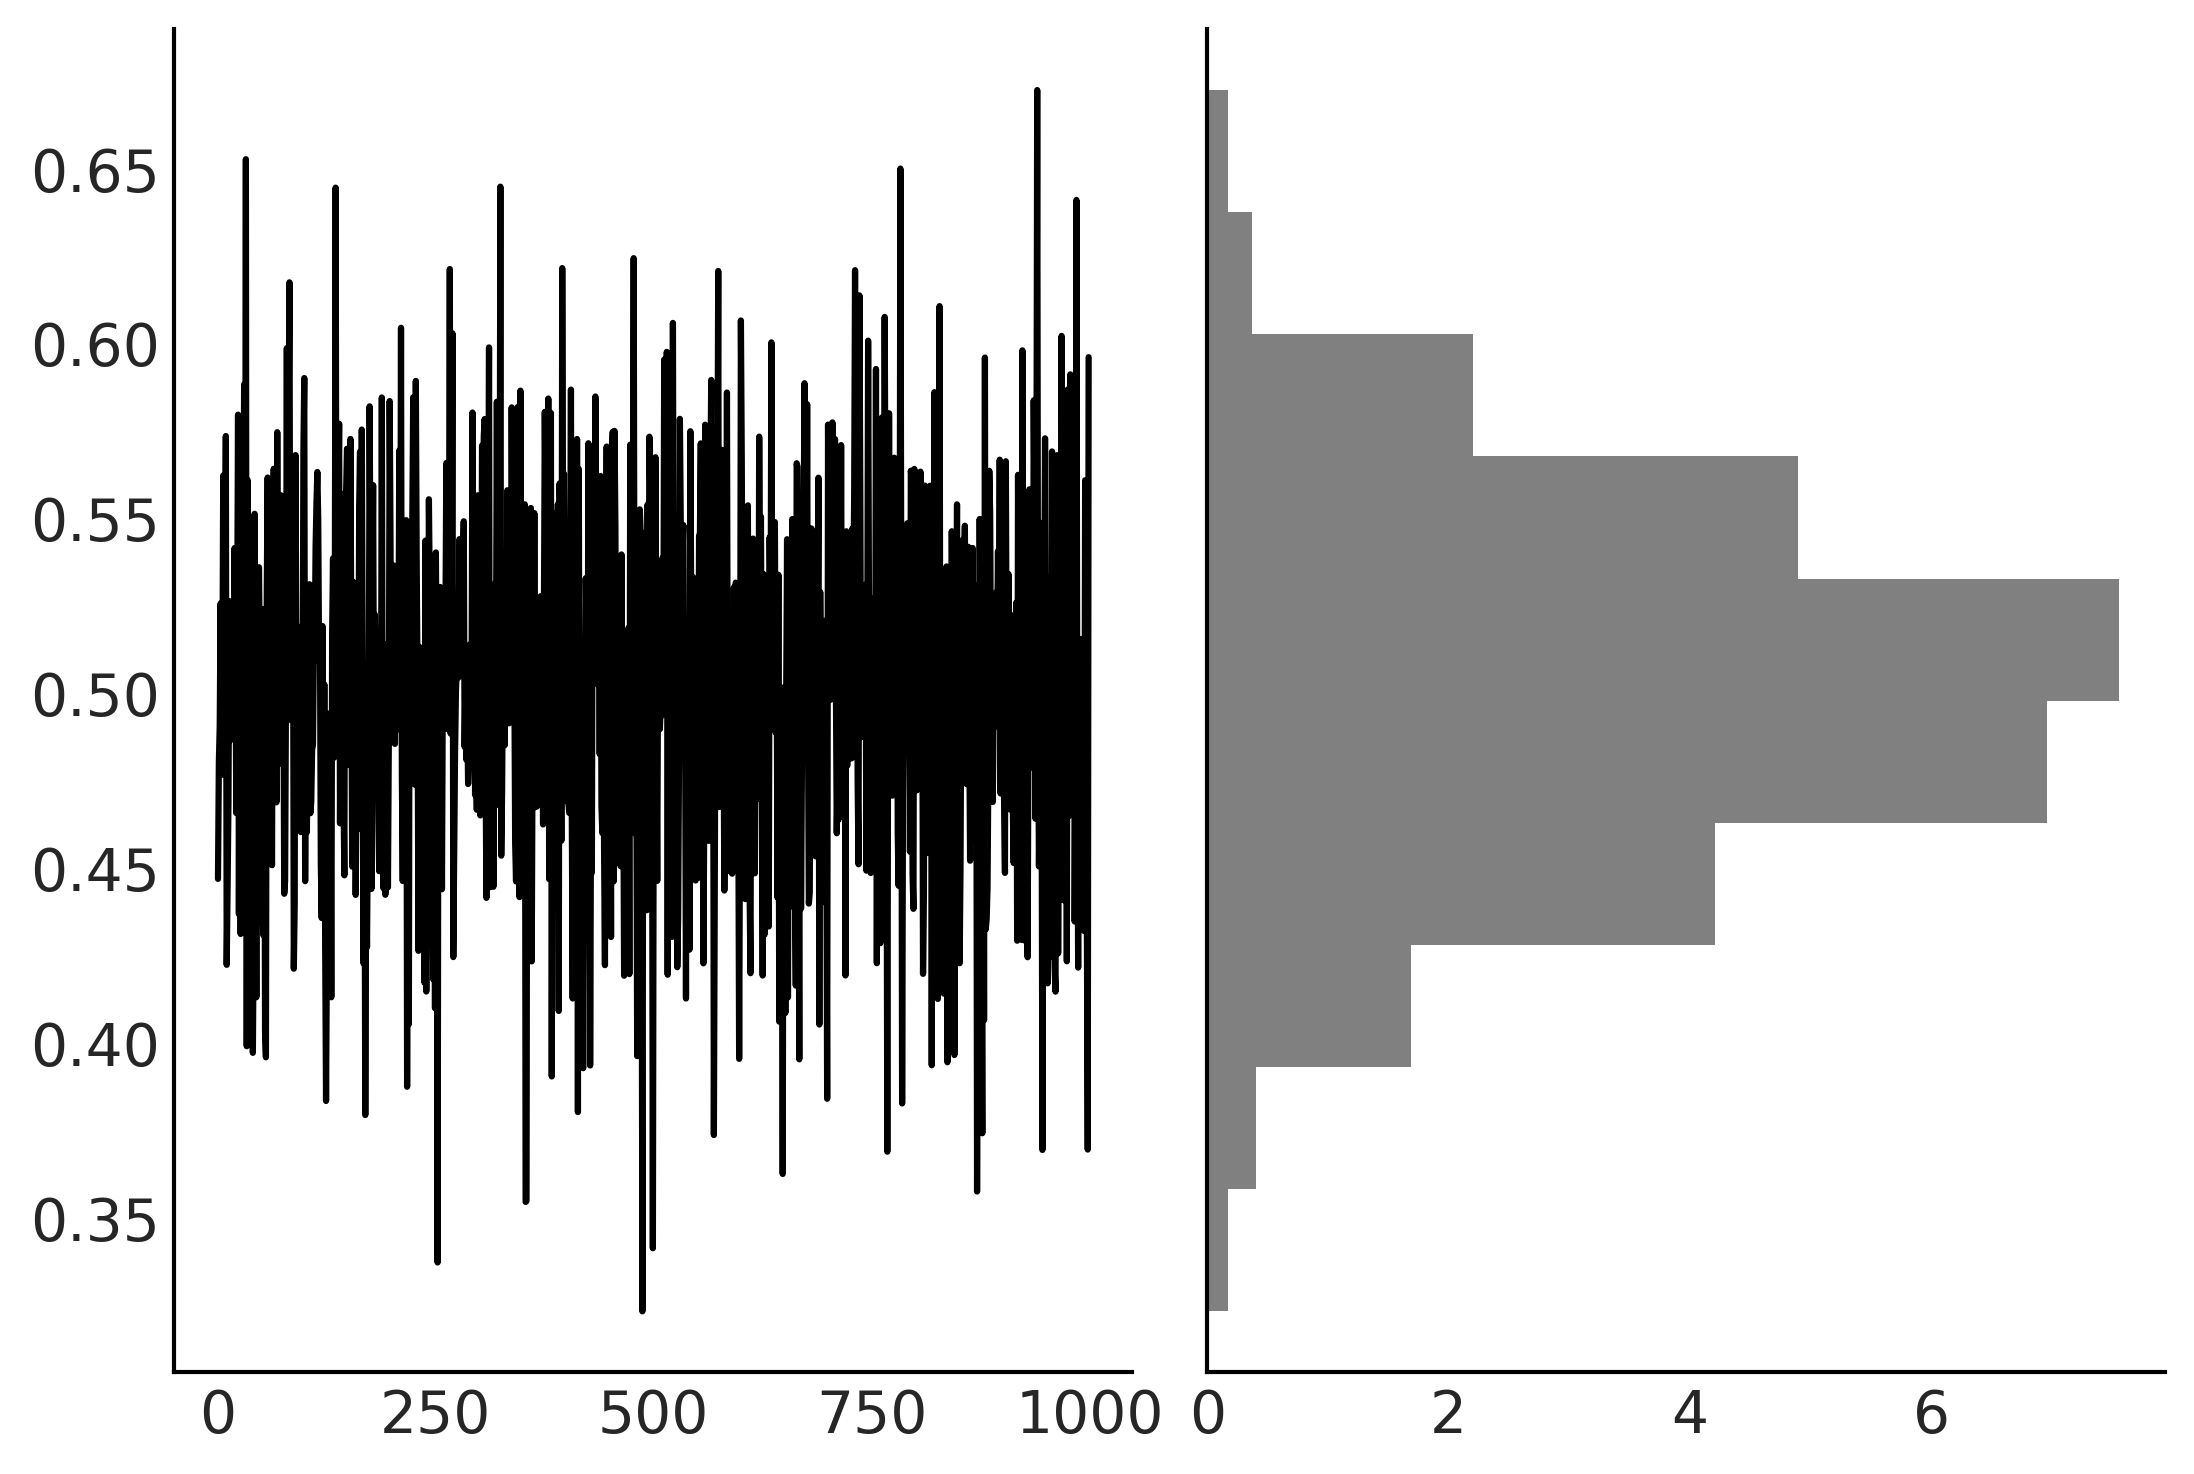

In [8]:
_, axes = plt.subplots(1,2, sharey=True)
axes[0].plot(trace["θ"])
axes[1].hist(trace["θ"], color="0.5", orientation="horizontal", density=True)

In [9]:
az.summary(trace, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
θ,0.5,0.05,0.41,0.6


In [10]:
print(len(trace["θ"]))

1000


<Axes: title={'center': 'θ'}>

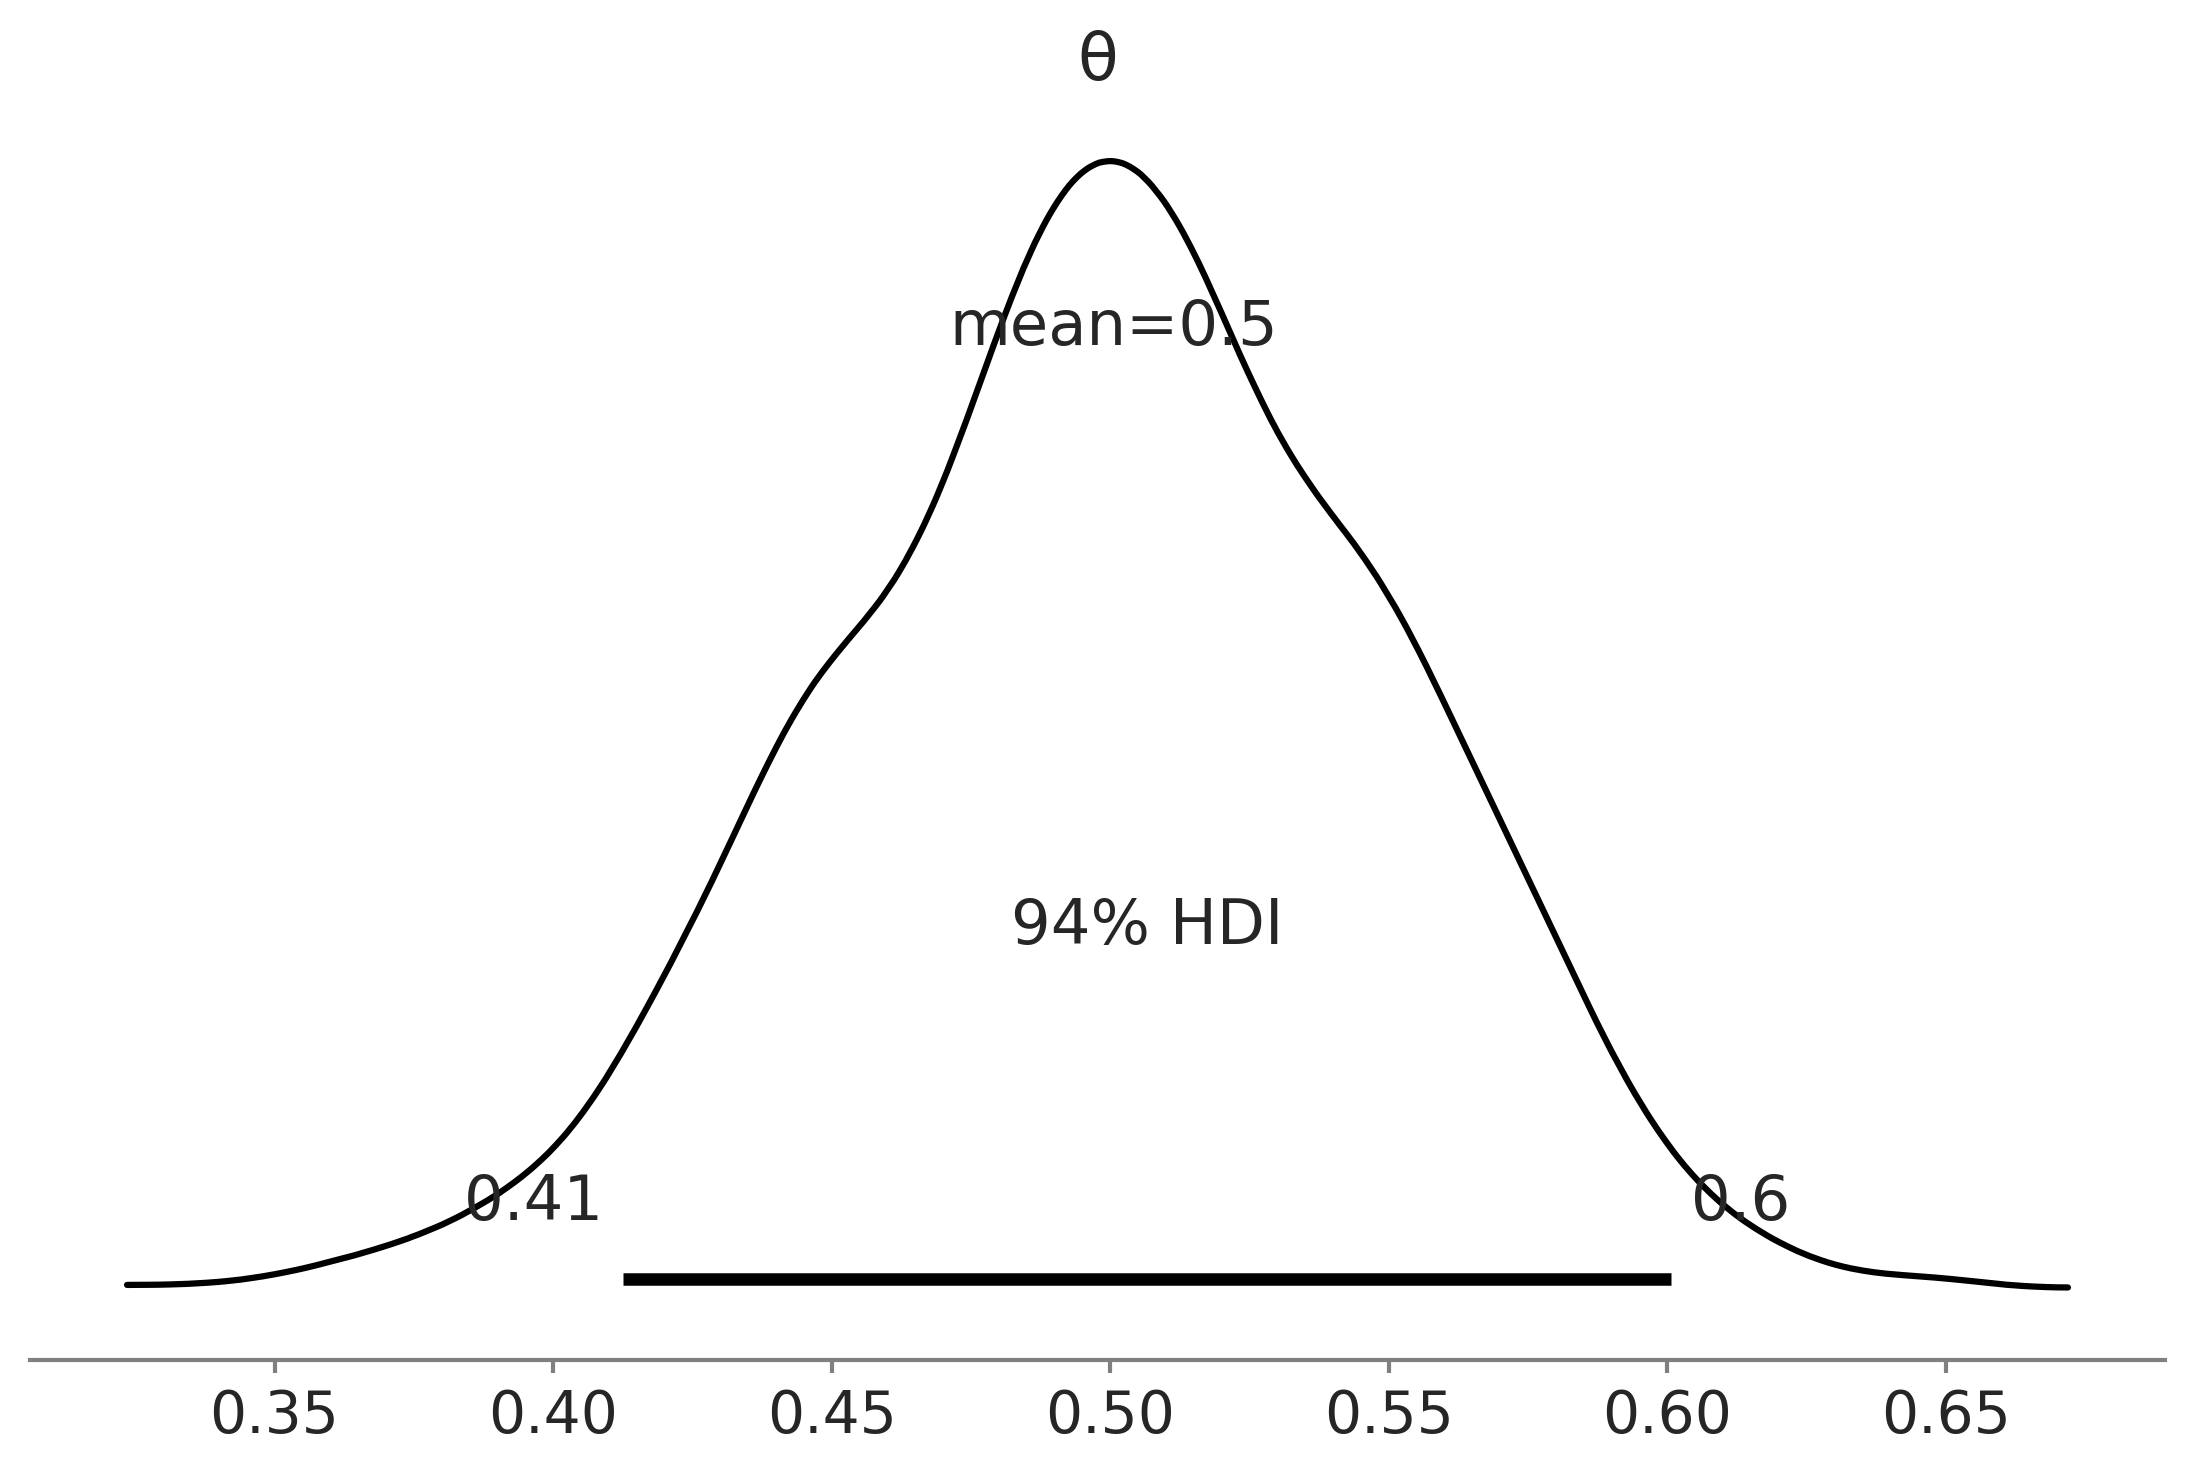

In [11]:
az.plot_posterior(trace)

# Using a Probabalistic Programming Language

In [12]:
# declare a model in PyMC3
with pm.Model() as model:
    # Specify the prior distribution of unknown parameter
    θ = pm.Beta("θ", alpha=1, beta=1)
    # Specify the likelihood distribution and condition on the observed data
    y_obs = pm.Binomial("y_obs", n=1, p=θ, observed=Y)
    # Sample from the posterior distribution
    idata = pm.sample(draws=1000, return_inferencedata=True)
        

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


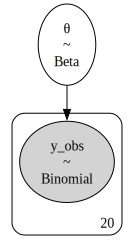

In [13]:
graphviz = pm.model_to_graphviz(model)
graphviz

In [14]:
pred_dists = (pm.sample_prior_predictive(1000, model).prior_predictive["y_obs"].values,
              pm.sample_posterior_predictive(idata, model).posterior_predictive["y_obs"].values)

Sampling: [y_obs, θ]
Sampling: [y_obs]


/var/folders/cv/lyq7thfd5vq3gsdqhrns_qdr0000gn/T/ipykernel_68975/2993779186.py:20: RuntimeWarning: invalid value encountered in divide
  axes[idx].plot(np.divide(y, N), 0, color='k', marker='o', ms=12)


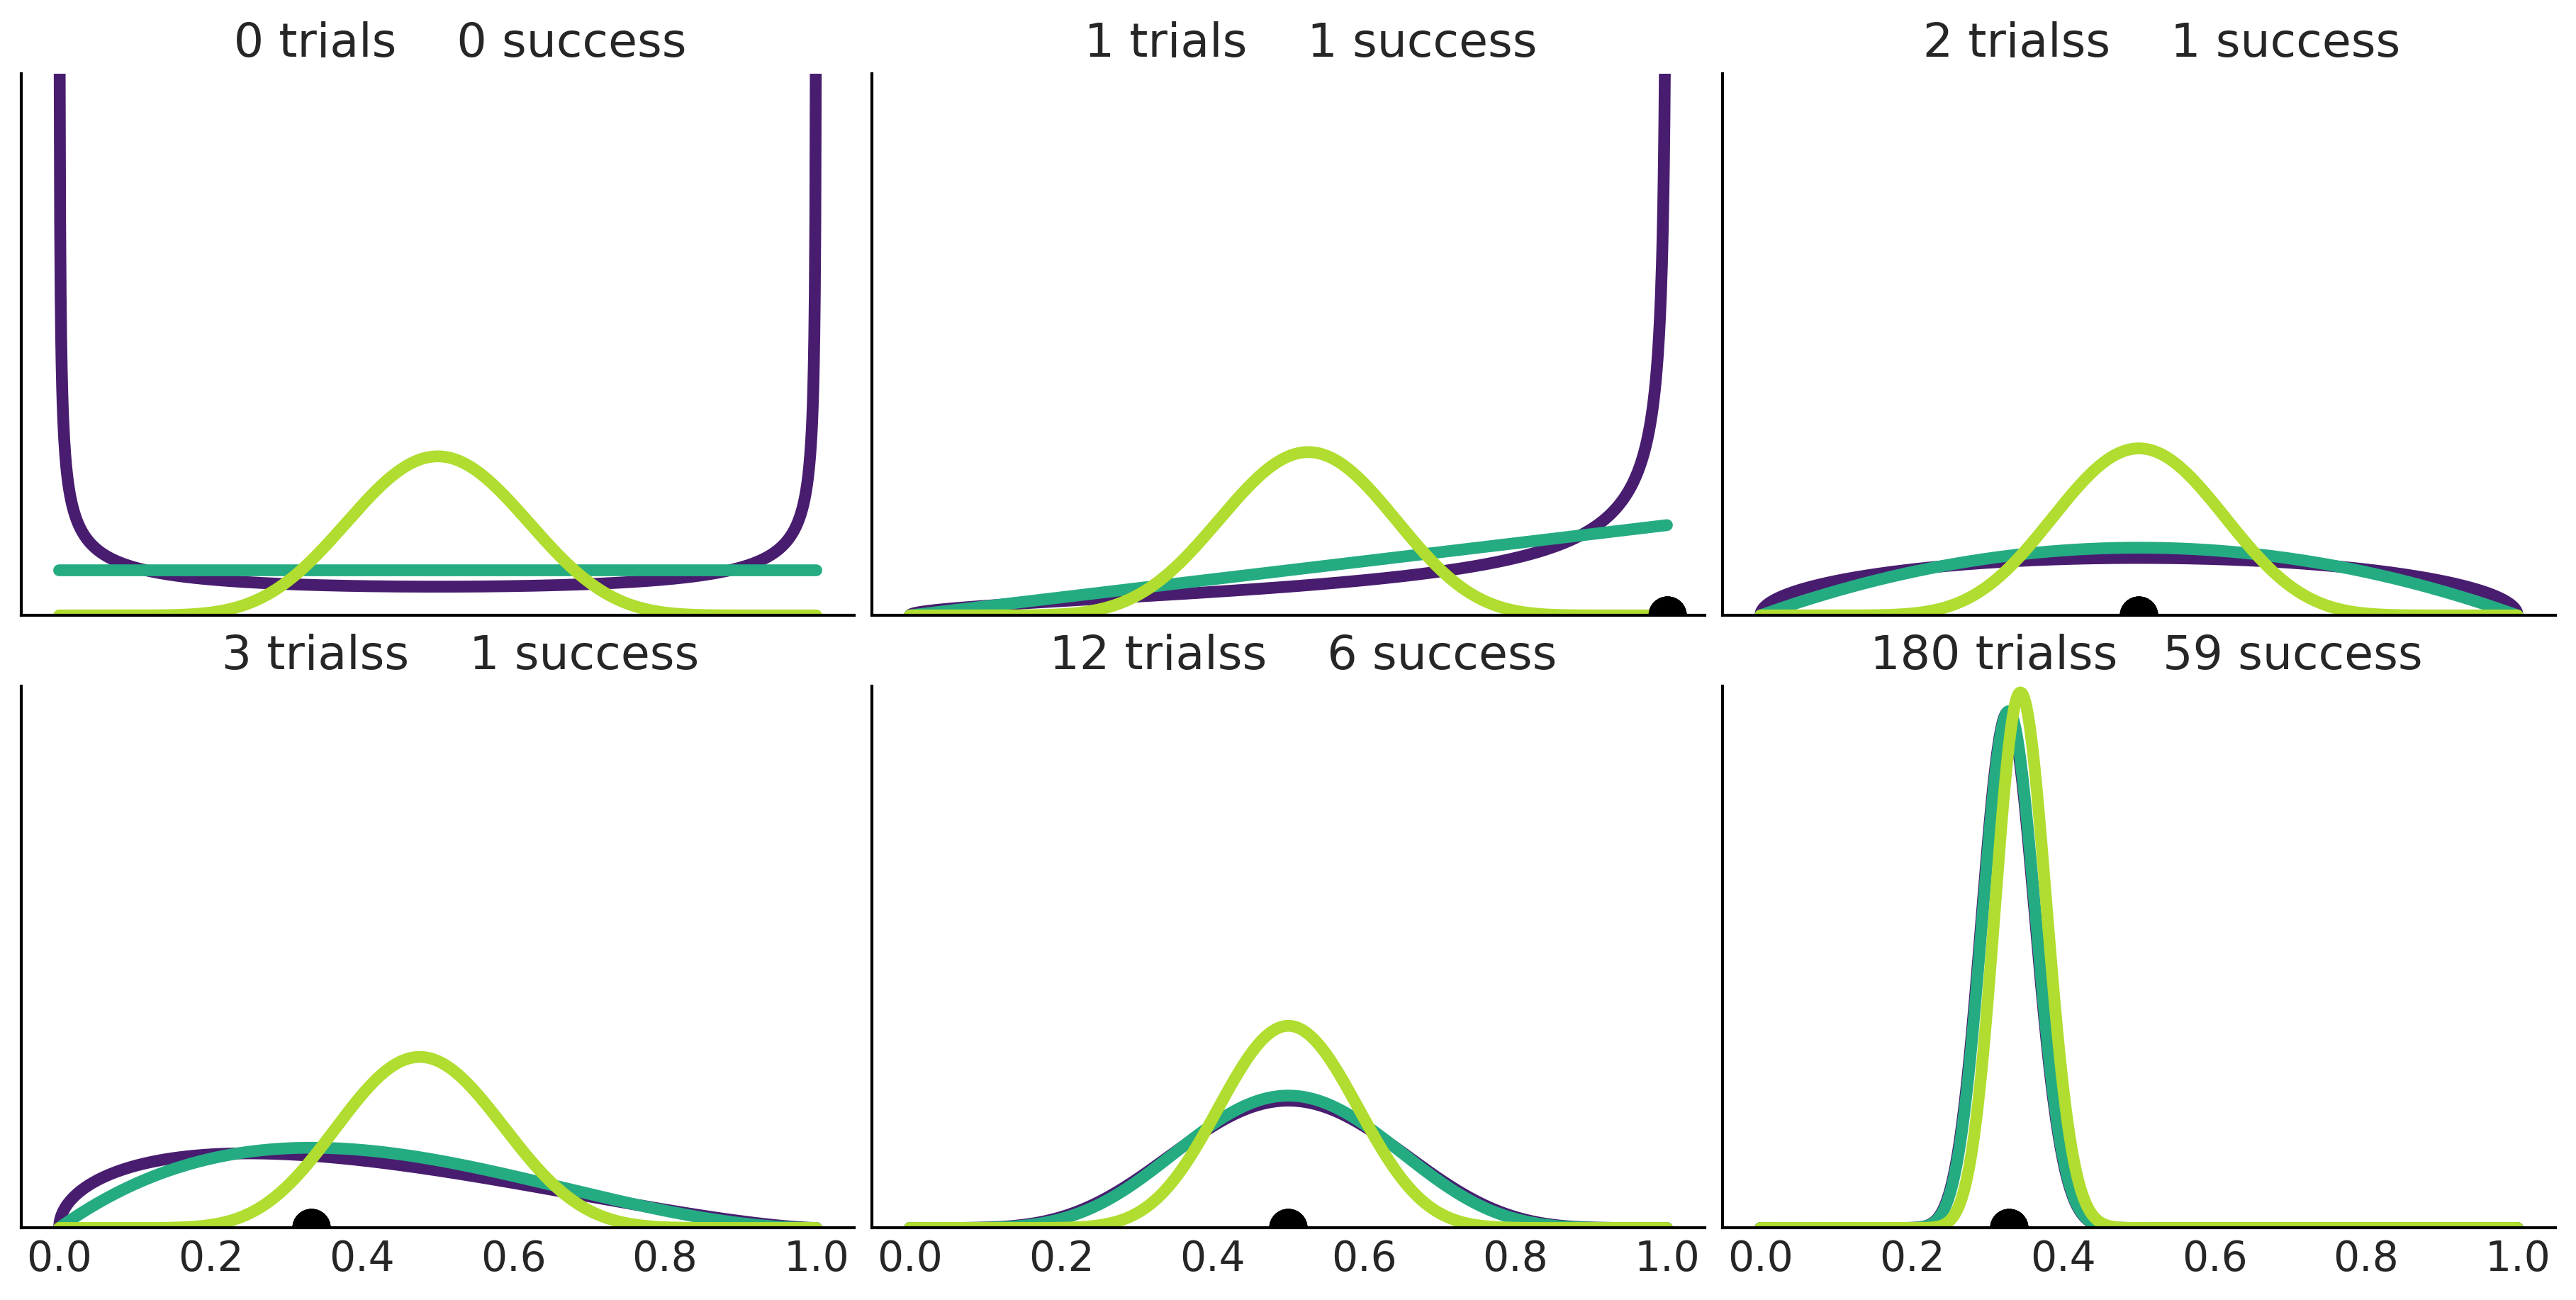

In [15]:
_, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True, sharex=True, constrained_layout=True)
axes = np.ravel(axes)

n_trials = [0, 1, 2, 3, 12, 180]
success = [0, 1, 1, 1, 6, 59]
data = zip(n_trials, success)

beta_params = [(0.5, 0.5), (1, 1), (10, 10)]

θ = np.linspace(0, 1, 1500)

for idx, (N, y) in enumerate(data):
    s_n = ('s' if (N > 1) else '')
    for jdx, (a_prior, b_prior) in enumerate(beta_params):
        p_θ_given_y = stats.beta.pdf(θ, a_prior + y, b_prior + N - y)
        
        axes[idx].plot(θ, p_θ_given_y, lw=4, color=viridish[jdx])
        axes[idx].set_yticks([])
        axes[idx].set_ylim(0, 12)
        axes[idx].plot(np.divide(y, N), 0, color='k', marker='o', ms=12)
        axes[idx].set_title(f'{N:4d} trials{s_n} {y:4d} success')


from pathlib import Path
Path("img/chap01/").mkdir(parents=True, exist_ok=True)

plt.savefig('img/chap01/beta_binomial_update.png')


## Entropy Maximization

Text(0, 0.5, '$p(t)$')

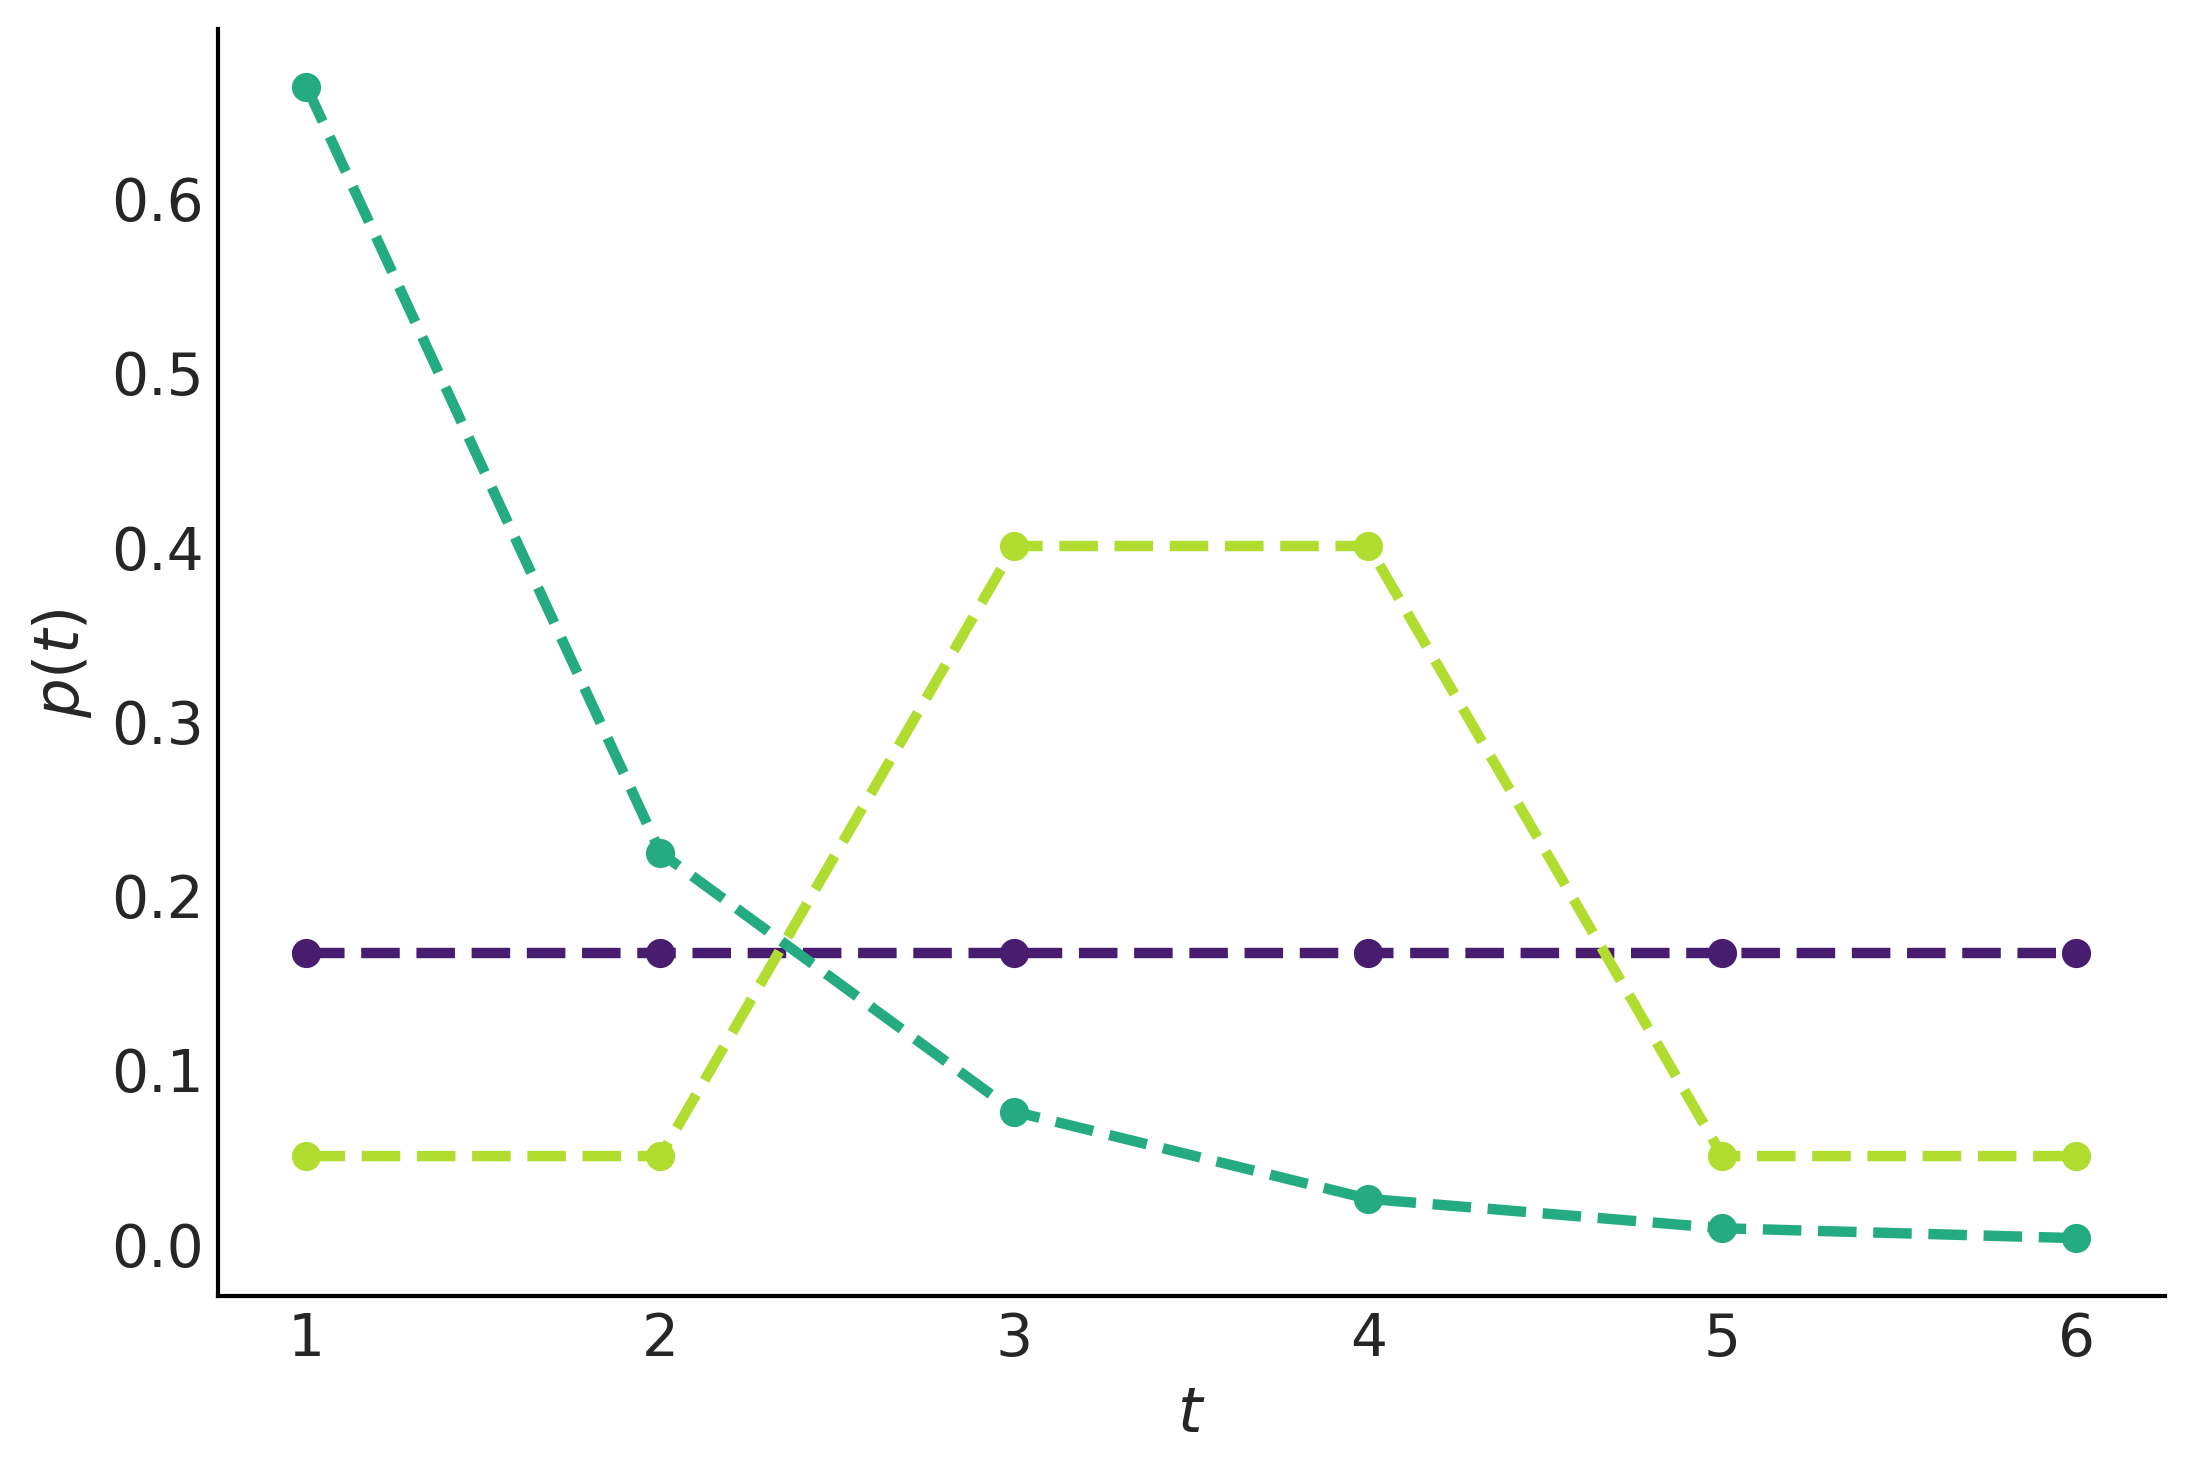

In [16]:
from scipy.optimize import minimize
from scipy.stats import entropy

cons = [
    [{"type": "eq", "fun": lambda x: np.sum(x) - 1}],
    [{"type": "eq", "fun": lambda x: np.sum(x) - 1}, {"type": "eq", "fun": lambda x: 1.5 - np.sum(x * np.arange(1, 7))}],
    [{"type": "eq", "fun": lambda x: np.sum(x) - 1},{"type": "eq", "fun": lambda x: np.sum(x[[2, 3]]) - 0.8}]
]

max_ent = []

for i, c in enumerate(cons):
    val = minimize(lambda x: -entropy(x), x0 = [1/6] * 6, bounds=[(0., 1.)] * 6,
                   constraints=c)['x']
    max_ent.append(entropy(val))
    plt.plot(np.arange(1, 7), val, 'o--', color=viridish[i], lw=2.5)

plt.xlabel("$t$")
plt.ylabel("$p(t)$")


In [17]:
ite = 100_000
entropies = np.zeros((3, ite))
for idx in range(ite):
    rnds = np.zeros(6)
    total = 0
    x_ = np.random.choice(np.arange(1, 7), size = 6, replace=False)
    for i in x_[:-1]:
        rnd = np.random.uniform(0, 1-total)
        rnds[i-1] = rnd
        total = rnds.sum()
    rnds[-1] = 1 - rnds[:-1].sum()
    
    H = entropy(rnds)
    
    entropies[0, idx] = H
    if abs(1.5 - np.sum(rnds*x_)) < 0.01:
        entropies[1, idx] = H
    prob_34 = sum(rnds[np.argwhere((x_ == 3) | (x_ == 4)).ravel()])
    if abs(0.8-prob_34) < 0.01:
        entropies[2, idx] = H
    

### Exercises
Ex 1E5a: Probability distribution of the number of customers that visit a coffee shop in an hour assuming visiting customers follow a Poisson distribution with an average of 15 customers in an hour.

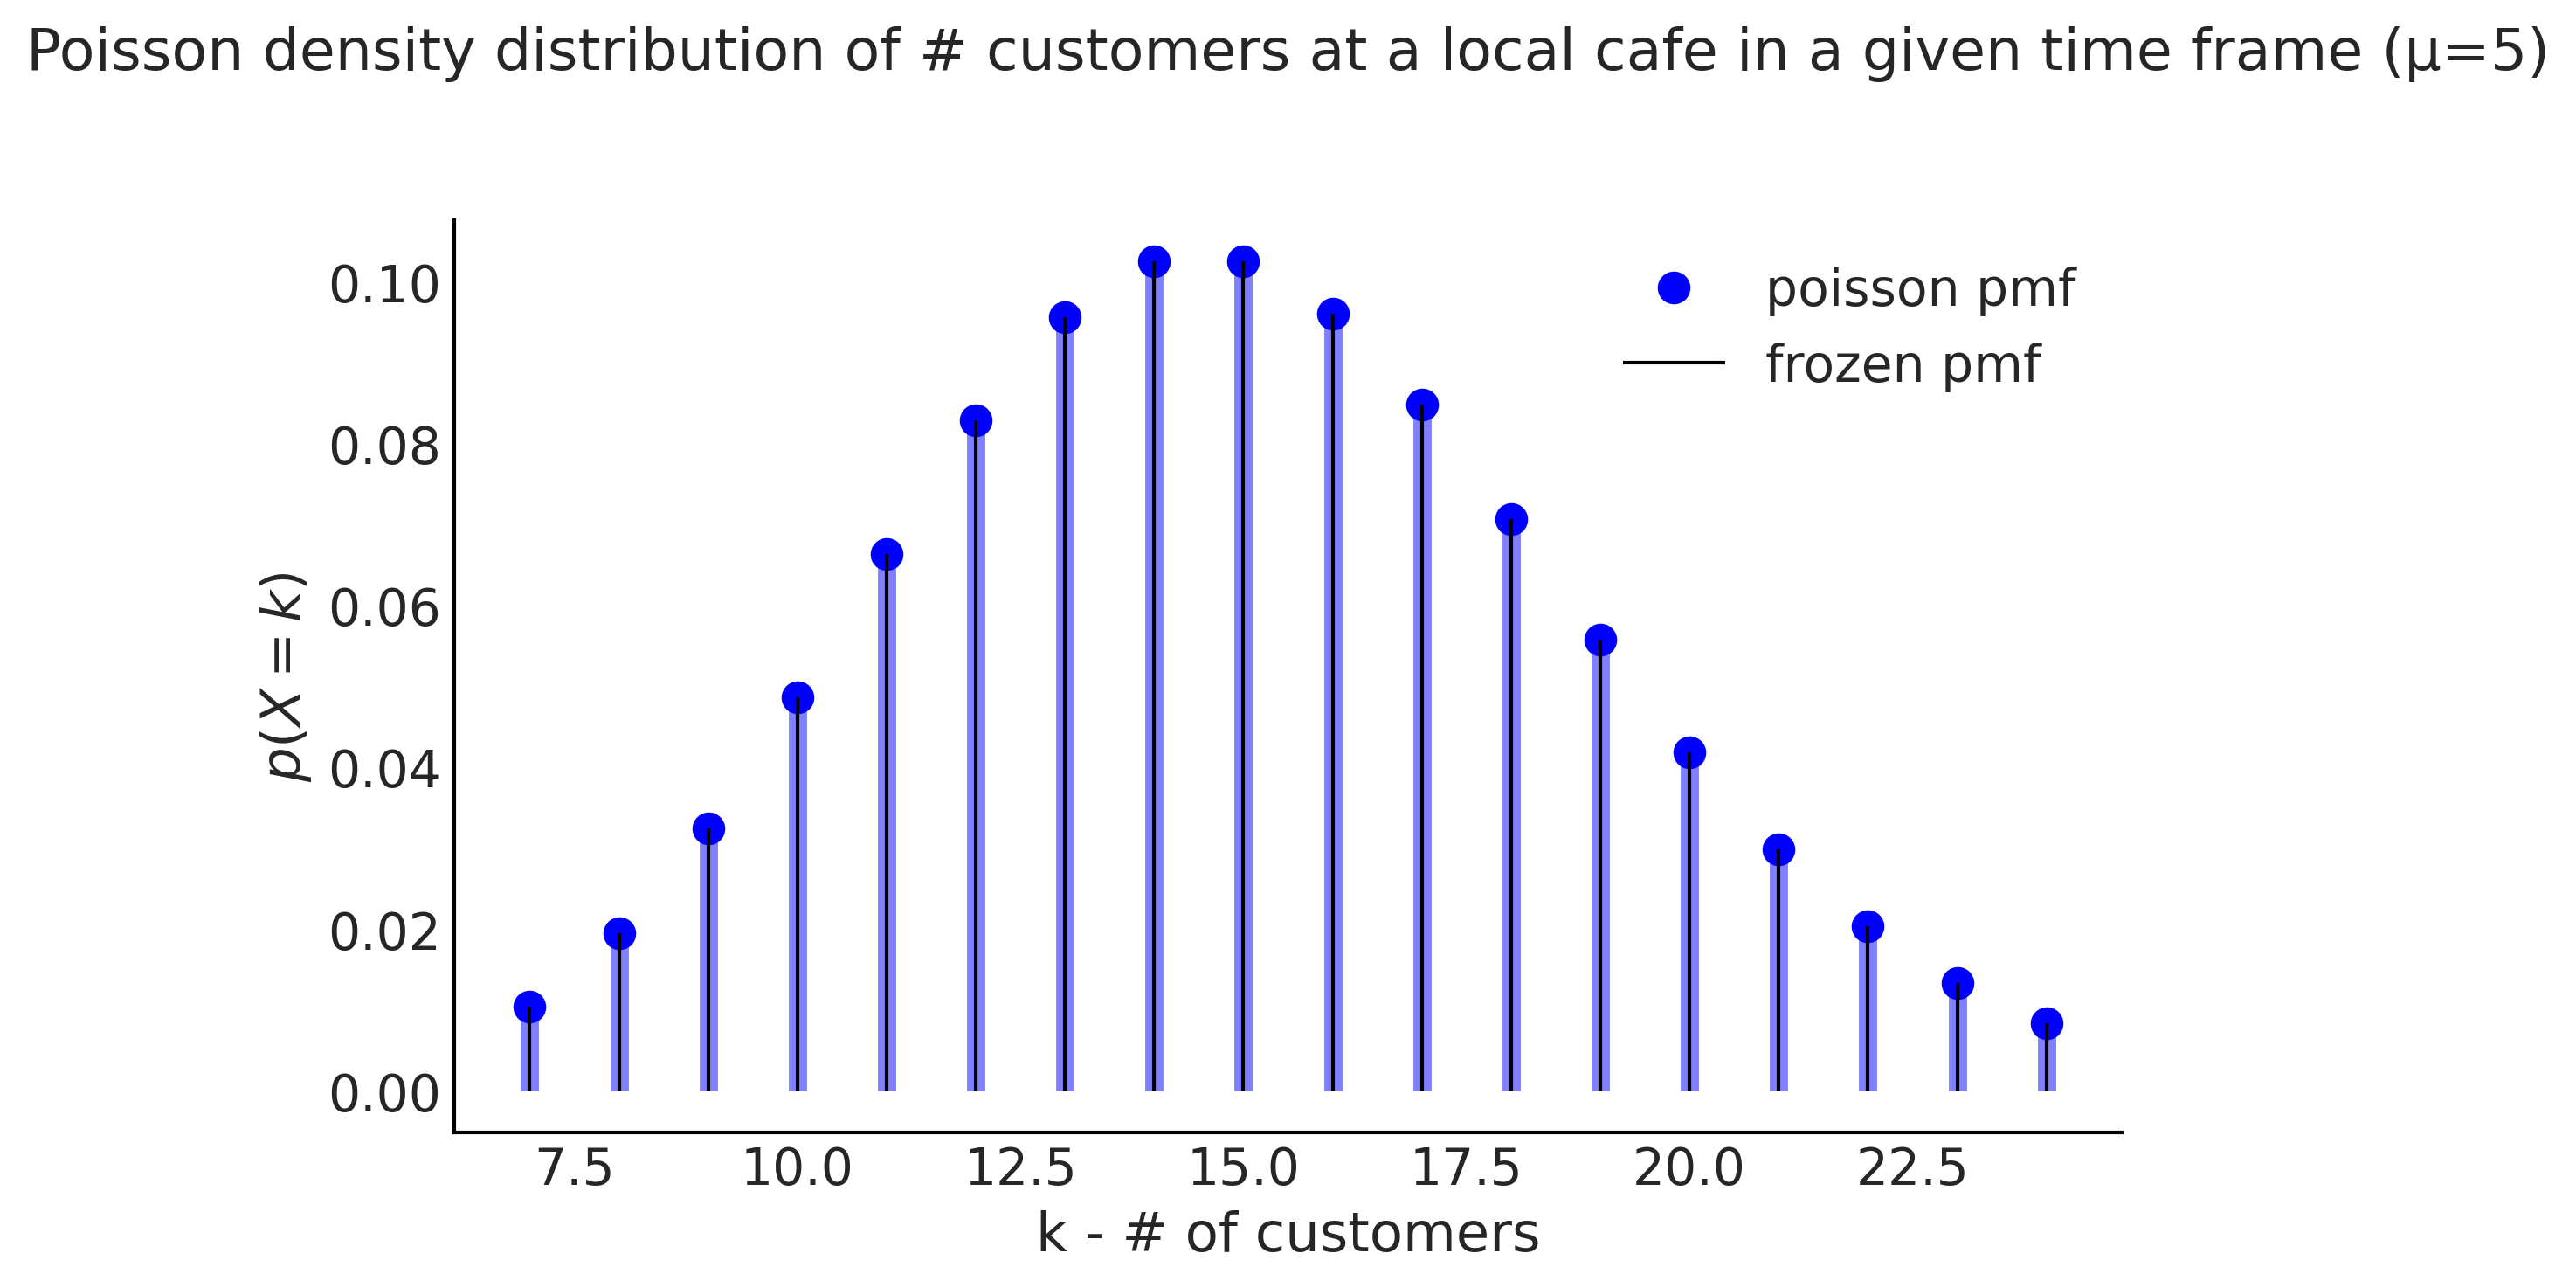

In [18]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

mu = 15
mean, var, skew, kurt = poisson.stats(mu, moments='mvsk')

x = np.arange(poisson.ppf(0.01, mu),
              poisson.ppf(0.99, mu))
ax.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)

rv = poisson(mu)
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
        label='frozen pmf')
ax.legend(loc='best', frameon=False)
plt.xlabel("k - # of customers")
plt.ylabel("$p(X=k)$")
plt.title("Poisson density distribution of # customers at a local cafe in a given time frame (μ=5)\n\n")
ax.annotate('local maxddddd', xy=(2, 0.1), xytext=(10, 10))
plt.show()

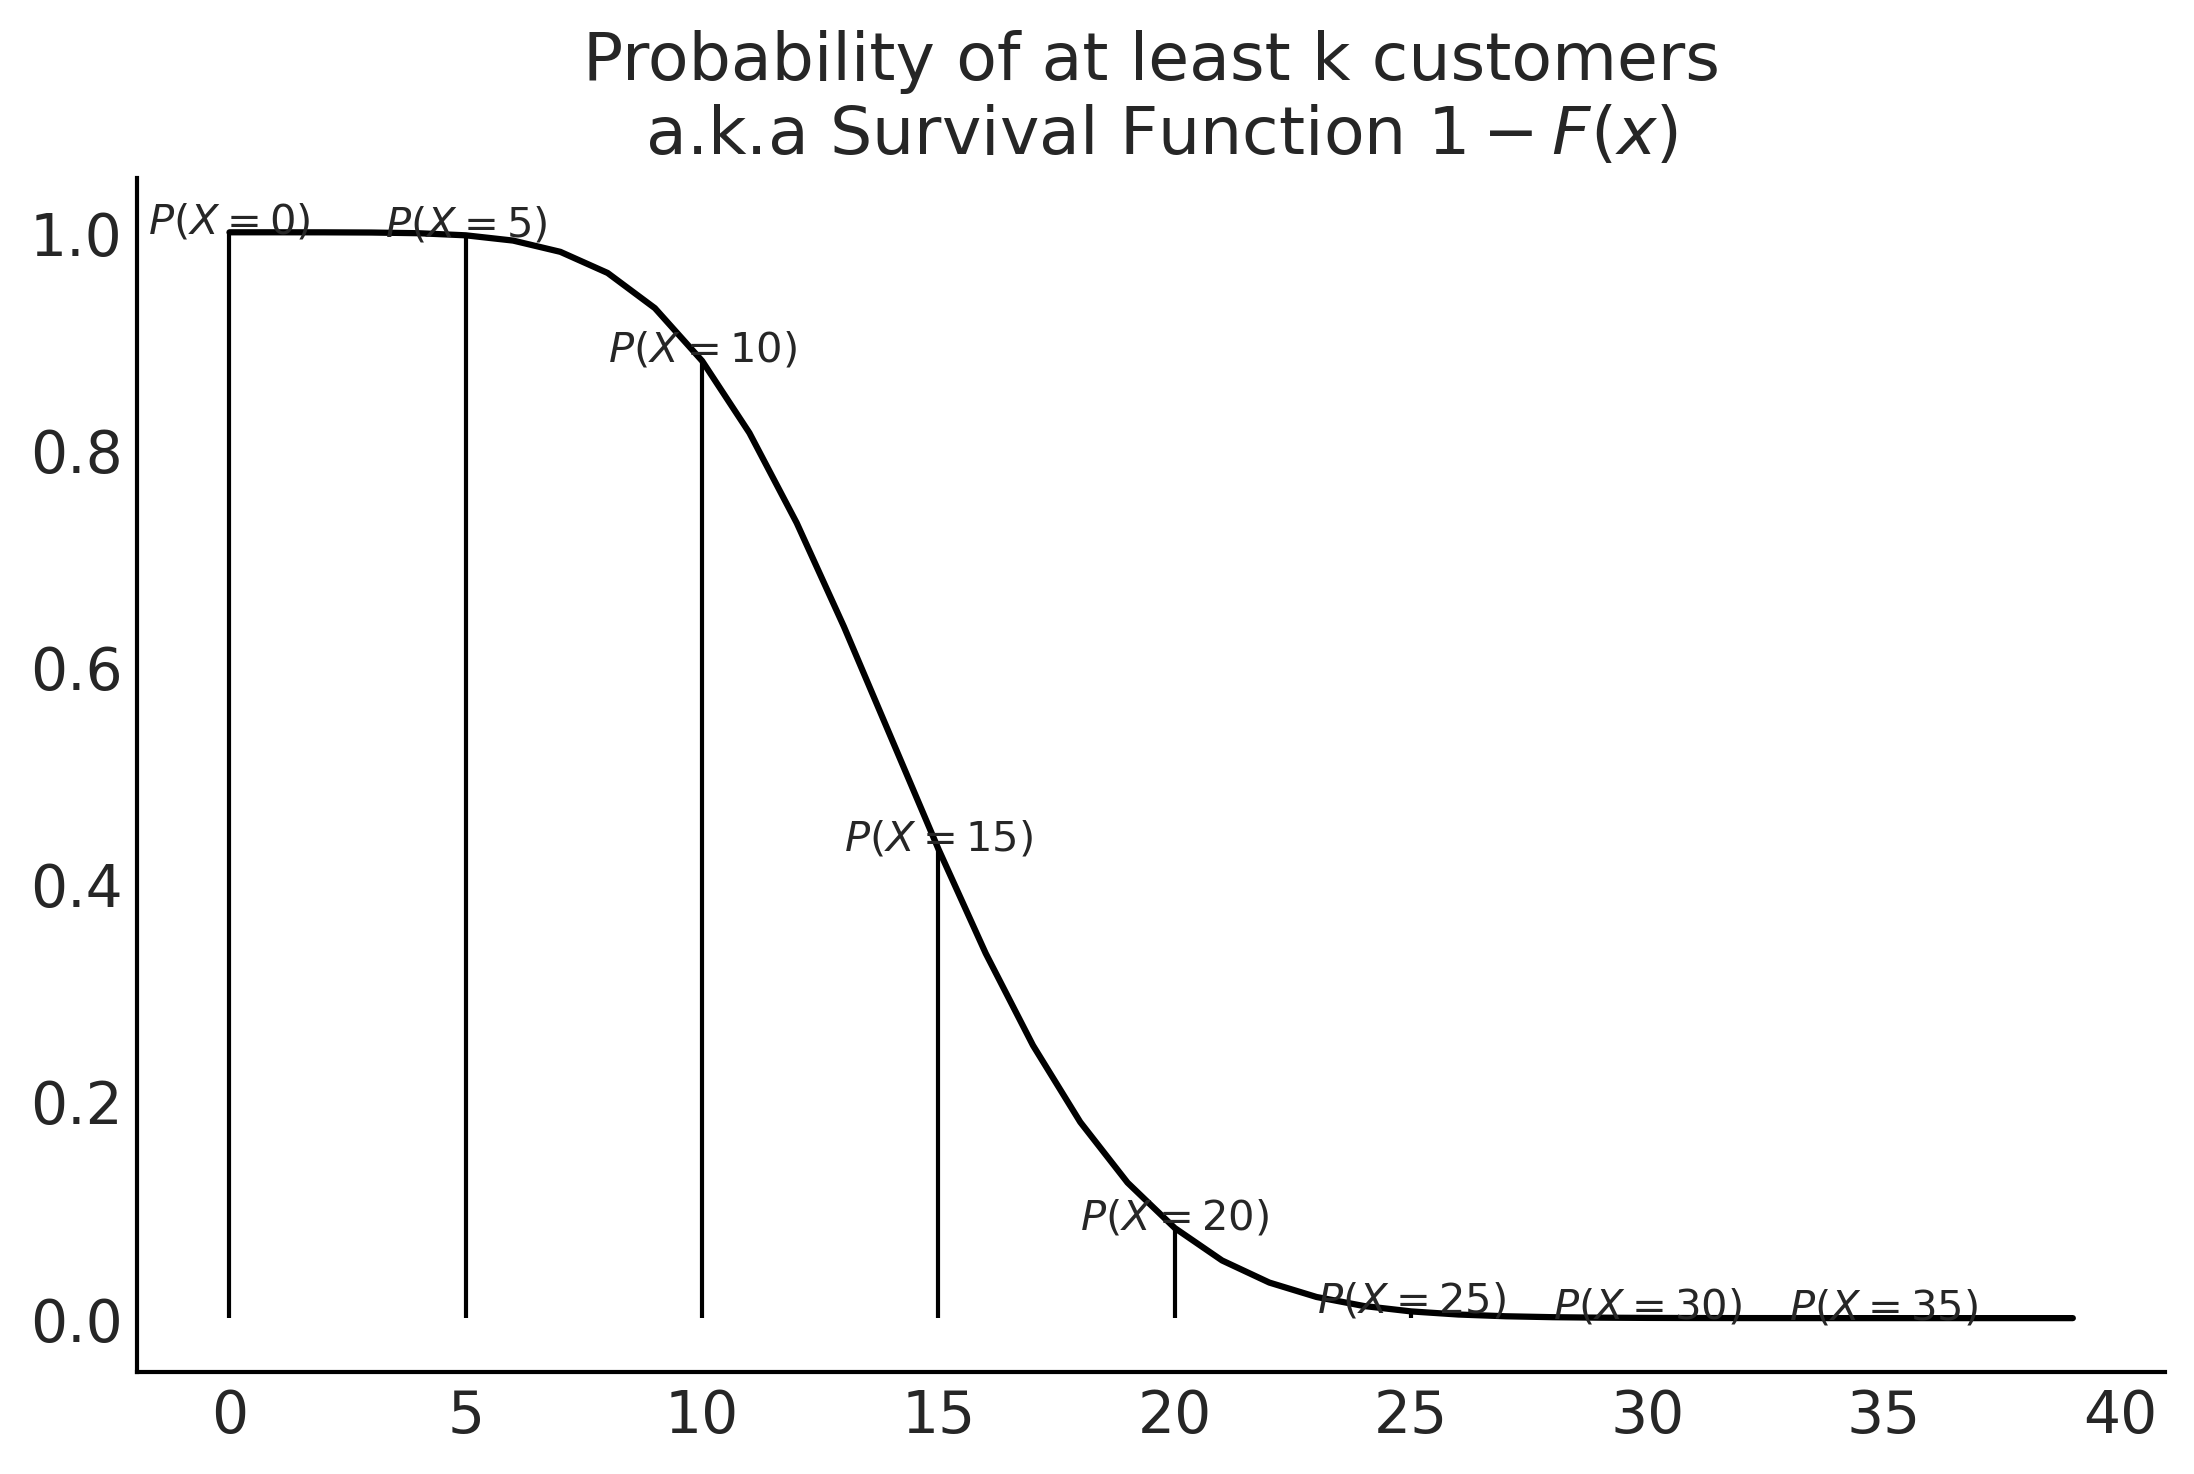

In [19]:
fig, ax = plt.subplots(1, 1)

def addlabels(x,y):
    for i in range(len(x)):
        if i % 5 == 0:
            plt.text(i, y[i], "$P(X={x})$".format(x=i), ha = 'center')
            ax.vlines(i, 0, y[i], colors='k', linestyles='-', lw=1,label='frozen pmf')

        
mu = 15
mean, var, skew, kurt = poisson.stats(mu, moments='mvsk')

x = np.arange(0, 40)
y = poisson.cdf(x, mu)

y = np.ones(40) - y

ax.plot(x, y)
addlabels(x, y)

plt.title("Probability of at least k customers\n a.k.a Survival Function $1-F(x)$")
plt.show()